# Lane Detection Project

We are going to use TuSimple dataset for a lane detection.

All necessary imports in one place.

In [1]:
# Importing necessary libraries
import json  # For working with JSON data
import os    # For interacting with the operating system

import cv2   # OpenCV library for computer vision tasks
import matplotlib.pyplot as plt  # Matplotlib for plotting
import numpy as np  # NumPy for numerical operations
from sklearn.cluster import DBSCAN  # DBSCAN for density-based clustering
import torch  # PyTorch for deep learning
import torch.nn as nn  # PyTorch's neural network module
from torch.nn.modules.loss import _Loss  # Base class for PyTorch loss functions
from torch.autograd import Variable  # Autograd for automatic differentiation

## Overview of Data

In [2]:
# !cat /kaggle/input/tusimple/TUSimple/train_set/readme.md

In [3]:
# Creating an empty list to store data
data = []

# Opening and reading a JSON file containing label data
with open("./train_set/label_data_0313.json") as f:
    # Iterating over each line in the file
    for line in f:
        # Parsing each line as JSON and appending it to the 'data' list
        data.append(json.loads(line))

# Printing the total number of entries in the 'data' list
print(len(data))

# Printing the data at index 21 in the 'data' list
print(data[21])

2858
{'lanes': [[-2, -2, -2, -2, 730, 705, 681, 661, 640, 619, 598, 577, 556, 535, 514, 493, 472, 451, 433, 416, 398, 381, 363, 346, 328, 311, 293, 276, 258, 241, 223, 205, 188, 170, 153, 135, 118, 100, 83, 65, 48, 30, 12, -2, -2, -2, -2, -2], [-2, -2, 884, 848, 831, 816, 816, 815, 815, 814, 814, 814, 817, 820, 823, 826, 829, 832, 835, 838, 842, 845, 848, 851, 854, 857, 860, 863, 866, 869, 872, 875, 878, 881, 885, 888, 891, 894, 897, 900, 903, 906, 909, 912, 915, 918, 921, 924], [-2, -2, -2, 683, 630, 585, 539, 493, 448, 405, 361, 318, 275, 232, 189, 146, 102, 59, 16, -2, -2, -2, -2, -2, -2, -2, -2, -2, -2, -2, -2, -2, -2, -2, -2, -2, -2, -2, -2, -2, -2, -2, -2, -2, -2, -2, -2, -2], [-2, -2, 923, 915, 923, 930, 947, 967, 986, 1005, 1024, 1043, 1065, 1088, 1111, 1135, 1158, 1181, 1204, 1227, 1250, 1274, -2, -2, -2, -2, -2, -2, -2, -2, -2, -2, -2, -2, -2, -2, -2, -2, -2, -2, -2, -2, -2, -2, -2, -2, -2, -2]], 'h_samples': [240, 250, 260, 270, 280, 290, 300, 310, 320, 330, 340, 350, 360, 3

## Semantic and Segmentation Code

We can use the following commands to download the dataset and unpack it from google drive

This is done by creating a class LaneDataSet

We create an instance of the LaneDataset class and retrieving the first item from it. The resulting im, s, and ins are likely the input image, segmentation image, and instance image, respectively

In [4]:
class LaneDataset(torch.utils.data.Dataset):
    def __init__(self, dataset_path="./train_set", train=True, size=(512, 256)):
        self._dataset_path = dataset_path
        self._mode = "train" if train else "eval"
        self._image_size = size # w, h

        if self._mode == "train":
            label_files = [
                os.path.join(self._dataset_path, f"label_data_{suffix}.json")
                for suffix in ("0313", "0531")
            ]
        elif self._mode == "eval":
            label_files = [
                os.path.join(self._dataset_path, f"label_data_{suffix}.json")
                for suffix in ("0601",)
            ]

        self._data = []

        for label_file in label_files:
            self._process_label_file(label_file)

    def __getitem__(self, idx):
        image_path = os.path.join(self._dataset_path, self._data[idx][0])
        image = cv2.imread(image_path)
        h, w, c = image.shape
        image = cv2.resize(image, self._image_size, interpolation=cv2.INTER_LINEAR)
        image = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
        image = image[..., None]
        lanes = self._data[idx][1]

        segmentation_image = self._draw(h, w, lanes, "segmentation")
        instance_image = self._draw(h, w, lanes, "instance")

        instance_image = instance_image[..., None]

        image = torch.from_numpy(image).float().permute((2, 0, 1))
        segmentation_image = torch.from_numpy(segmentation_image.copy())
        instance_image =  torch.from_numpy(instance_image.copy()).permute((2, 0, 1))
        segmentation_image = segmentation_image.to(torch.int64)

        return image, segmentation_image, instance_image # 1 x H x W [[0, 1], [2, 0]]
    
    def __len__(self):
        return len(self._data)

    def _draw(self, h, w, lanes, image_type):
        image = np.zeros((h, w), dtype=np.uint8)
        for i, lane in enumerate(lanes):
            color = 1 if image_type == "segmentation" else i + 1
            cv2.polylines(image, [lane], False, color, 10)

        image = cv2.resize(image, self._image_size, interpolation=cv2.INTER_NEAREST)

        return image

    def _process_label_file(self, file_path):
        with open(file_path) as f:
            for line in f:
                info = json.loads(line)
                image = info["raw_file"]
                lanes = info["lanes"]
                h_samples = info["h_samples"]
                lanes_coords = []
                for lane in lanes:
                    x = np.array([lane]).T
                    y = np.array([h_samples]).T
                    xy = np.hstack((x, y))
                    idx = np.where(xy[:, 0] > 0)
                    lane_coords = xy[idx]
                    lanes_coords.append(lane_coords)
                self._data.append((image, lanes_coords))


Test the dataset class.

In this context:

- im is the input image tensor with shape (channel, height, width).
- s is the segmentation image tensor with shape (height, width).
- ins is the instance image tensor with shape (channel, height, width).
This code snippet demonstrates how to access and inspect the shapes of the images from the LaneDataset. You can use these images for further processing or analysis in your lane detection model.

In [5]:
lanes = LaneDataset()
im, s, ins = lanes[0]
im.shape, s.shape, ins.shape

(torch.Size([1, 256, 512]), torch.Size([256, 512]), torch.Size([1, 256, 512]))

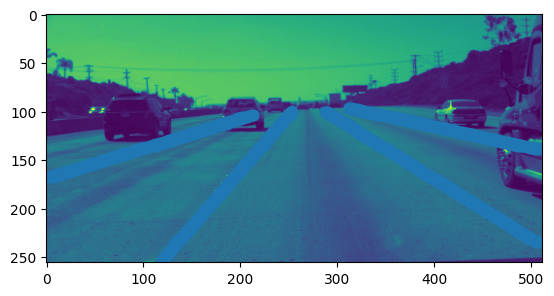

In [6]:
plt.imshow(im.squeeze())
plt.scatter(x=ins.nonzero(as_tuple=True)[2], y=ins.nonzero(as_tuple=True)[1])

For this task we are going to use ENet architecture. You can read the description in the .

This code defines an implementation of ENet, a deep neural network architecture designed for real-time semantic segmentation. The ENet architecture consists of an initial block, followed by shared and specific branches for segmentation and instance embedding. A brief description can be found in this [paper](https://arxiv.org/pdf/1606.02147.pdf)

Here's a brief overview of the key components and stages:

- Initial Block (InitialBlock class):

This block serves as the initial layer of the network.
It has a main branch (convolution) and an extension branch (max-pooling).
The branches are concatenated and passed through batch normalization and activation.
- Regular Bottleneck (RegularBottleneck class):

This represents a regular bottleneck block with main and extension branches.
The extension branch may include asymmetric, dilated, or regular convolution.
Batch normalization and activation functions are applied after each convolution.
- Downsampling Bottleneck (DownsamplingBottleneck class):

Similar to the regular bottleneck but includes max pooling in the main branch.
The extension branch performs convolution operations.
This block is used for downsampling.
- Upsampling Bottleneck (UpsamplingBottleneck class):

Similar to the regular bottleneck but includes transposed convolution for upsampling.
Used for upsampling in the decoding part of the network.
- ENet (ENet class):

The main ENet model composed of initial, shared, and specific branches.
Shared branches include downsampling and regular bottlenecks.
Specific branches include binary and instance embedding branches.
- Forward Method:

The forward method defines the forward pass through the network.
It includes the initial block, shared branches, and specific branches for both binary segmentation and instance embedding.

The network takes an input tensor and produces two outputs: binary_final_logits for binary segmentation and instance_final_logits for instance embedding.

In [7]:
class InitialBlock(nn.Module):
    def __init__(self,
                 in_channels,
                 out_channels,
                 bias=False,
                 relu=True):
        super().__init__()

        if relu:
            activation = nn.ReLU
        else:
            activation = nn.PReLU

        # Main branch - As stated above the number of output channels for this
        # branch is the total minus 3, since the remaining channels come from
        # the extension branch
        self.main_branch = nn.Conv2d(
            in_channels,
            out_channels - 1,
            kernel_size=3,
            stride=2,
            padding=1,
            bias=bias)

        # Extension branch
        self.ext_branch = nn.MaxPool2d(3, stride=2, padding=1)

        # Initialize batch normalization to be used after concatenation
        self.batch_norm = nn.BatchNorm2d(out_channels)

        # PReLU layer to apply after concatenating the branches
        self.out_activation = activation()

    def forward(self, x):
        main = self.main_branch(x)
        ext = self.ext_branch(x)

        # Concatenate branches
        out = torch.cat((main, ext), 1)

        # Apply batch normalization
        out = self.batch_norm(out)

        return self.out_activation(out)


class RegularBottleneck(nn.Module):
    def __init__(self,
                 channels,
                 internal_ratio=4,
                 kernel_size=3,
                 padding=0,
                 dilation=1,
                 asymmetric=False,
                 dropout_prob=0,
                 bias=False,
                 relu=True):
        super().__init__()

        # Check in the internal_scale parameter is within the expected range
        # [1, channels]
        if internal_ratio <= 1 or internal_ratio > channels:
            raise RuntimeError("Value out of range. Expected value in the "
                               "interval [1, {0}], got internal_scale={1}."
                               .format(channels, internal_ratio))

        internal_channels = channels // internal_ratio

        if relu:
            activation = nn.ReLU
        else:
            activation = nn.PReLU

        # Main branch - shortcut connection

        # Extension branch - 1x1 convolution, followed by a regular, dilated or
        # asymmetric convolution, followed by another 1x1 convolution, and,
        # finally, a regularizer (spatial dropout). Number of channels is constant.

        # 1x1 projection convolution
        self.ext_conv1 = nn.Sequential(
            nn.Conv2d(
                channels,
                internal_channels,
                kernel_size=1,
                stride=1,
                bias=bias), nn.BatchNorm2d(internal_channels), activation())

        # If the convolution is asymmetric we split the main convolution in
        # two. Eg. for a 5x5 asymmetric convolution we have two convolution:
        # the first is 5x1 and the second is 1x5.
        if asymmetric:
            self.ext_conv2 = nn.Sequential(
                nn.Conv2d(
                    internal_channels,
                    internal_channels,
                    kernel_size=(kernel_size, 1),
                    stride=1,
                    padding=(padding, 0),
                    dilation=dilation,
                    bias=bias), nn.BatchNorm2d(internal_channels), activation(),
                nn.Conv2d(
                    internal_channels,
                    internal_channels,
                    kernel_size=(1, kernel_size),
                    stride=1,
                    padding=(0, padding),
                    dilation=dilation,
                    bias=bias), nn.BatchNorm2d(internal_channels), activation())
        else:
            self.ext_conv2 = nn.Sequential(
                nn.Conv2d(
                    internal_channels,
                    internal_channels,
                    kernel_size=kernel_size,
                    stride=1,
                    padding=padding,
                    dilation=dilation,
                    bias=bias), nn.BatchNorm2d(internal_channels), activation())

        # 1x1 expansion convolution
        self.ext_conv3 = nn.Sequential(
            nn.Conv2d(
                internal_channels,
                channels,
                kernel_size=1,
                stride=1,
                bias=bias), nn.BatchNorm2d(channels), activation())

        self.ext_regul = nn.Dropout2d(p=dropout_prob)

        # PReLU layer to apply after adding the branches
        self.out_activation = activation()

    def forward(self, x):
        # Main branch shortcut
        main = x

        # Extension branch
        ext = self.ext_conv1(x)
        ext = self.ext_conv2(ext)
        ext = self.ext_conv3(ext)
        ext = self.ext_regul(ext)

        # Add main and extension branches
        out = main + ext

        return self.out_activation(out)


class DownsamplingBottleneck(nn.Module):
    def __init__(self,
                 in_channels,
                 out_channels,
                 internal_ratio=4,
                 return_indices=False,
                 dropout_prob=0,
                 bias=False,
                 relu=True):
        super().__init__()

        # Store parameters that are needed later
        self.return_indices = return_indices

        # Check in the internal_scale parameter is within the expected range
        # [1, channels]
        if internal_ratio <= 1 or internal_ratio > in_channels:
            raise RuntimeError("Value out of range. Expected value in the "
                               "interval [1, {0}], got internal_scale={1}. "
                               .format(in_channels, internal_ratio))

        internal_channels = in_channels // internal_ratio

        if relu:
            activation = nn.ReLU
        else:
            activation = nn.PReLU

        # Main branch - max pooling followed by feature map (channels) padding
        self.main_max1 = nn.MaxPool2d(
            2,
            stride=2,
            return_indices=return_indices)

        # Extension branch - 2x2 convolution, followed by a regular, dilated or
        # asymmetric convolution, followed by another 1x1 convolution. Number
        # of channels is doubled.

        # 2x2 projection convolution with stride 2
        self.ext_conv1 = nn.Sequential(
            nn.Conv2d(
                in_channels,
                internal_channels,
                kernel_size=2,
                stride=2,
                bias=bias), nn.BatchNorm2d(internal_channels), activation())

        # Convolution
        self.ext_conv2 = nn.Sequential(
            nn.Conv2d(
                internal_channels,
                internal_channels,
                kernel_size=3,
                stride=1,
                padding=1,
                bias=bias), nn.BatchNorm2d(internal_channels), activation())

        # 1x1 expansion convolution
        self.ext_conv3 = nn.Sequential(
            nn.Conv2d(
                internal_channels,
                out_channels,
                kernel_size=1,
                stride=1,
                bias=bias), nn.BatchNorm2d(out_channels), activation())

        self.ext_regul = nn.Dropout2d(p=dropout_prob)

        # PReLU layer to apply after concatenating the branches
        self.out_activation = activation()

    def forward(self, x):
        # Main branch shortcut
        if self.return_indices:
            main, max_indices = self.main_max1(x)
        else:
            main = self.main_max1(x)

        # Extension branch
        ext = self.ext_conv1(x)
        ext = self.ext_conv2(ext)
        ext = self.ext_conv3(ext)
        ext = self.ext_regul(ext)

        # Main branch channel padding
        n, ch_ext, h, w = ext.size()
        ch_main = main.size()[1]
        padding = torch.zeros(n, ch_ext - ch_main, h, w)

        # Before concatenating, check if main is on the CPU or GPU and
        # convert padding accordingly
        if main.is_cuda:
            padding = padding.cuda()

        # Concatenate
        main = torch.cat((main, padding), 1)

        # Add main and extension branches
        out = main + ext

        return self.out_activation(out), max_indices


class UpsamplingBottleneck(nn.Module):
    def __init__(self,
                 in_channels,
                 out_channels,
                 internal_ratio=4,
                 dropout_prob=0,
                 bias=False,
                 relu=True):
        super().__init__()

        # Check in the internal_scale parameter is within the expected range
        # [1, channels]
        if internal_ratio <= 1 or internal_ratio > in_channels:
            raise RuntimeError("Value out of range. Expected value in the "
                               "interval [1, {0}], got internal_scale={1}. "
                               .format(in_channels, internal_ratio))

        internal_channels = in_channels // internal_ratio

        if relu:
            activation = nn.ReLU
        else:
            activation = nn.PReLU

        # Main branch - max pooling followed by feature map (channels) padding
        self.main_conv1 = nn.Sequential(
            nn.Conv2d(in_channels, out_channels, kernel_size=1, bias=bias),
            nn.BatchNorm2d(out_channels))

        # Remember that the stride is the same as the kernel_size, just like
        # the max pooling layers
        self.main_unpool1 = nn.MaxUnpool2d(kernel_size=2)

        # Extension branch - 1x1 convolution, followed by a regular, dilated or
        # asymmetric convolution, followed by another 1x1 convolution. Number
        # of channels is doubled.

        # 1x1 projection convolution with stride 1
        self.ext_conv1 = nn.Sequential(
            nn.Conv2d(
                in_channels, internal_channels, kernel_size=1, bias=bias),
            nn.BatchNorm2d(internal_channels), activation())

        # Transposed convolution
        self.ext_tconv1 = nn.ConvTranspose2d(
            internal_channels,
            internal_channels,
            kernel_size=2,
            stride=2,
            bias=bias)
        self.ext_tconv1_bnorm = nn.BatchNorm2d(internal_channels)
        self.ext_tconv1_activation = activation()

        # 1x1 expansion convolution
        self.ext_conv2 = nn.Sequential(
            nn.Conv2d(
                internal_channels, out_channels, kernel_size=1, bias=bias),
            nn.BatchNorm2d(out_channels), activation())

        self.ext_regul = nn.Dropout2d(p=dropout_prob)

        # PReLU layer to apply after concatenating the branches
        self.out_activation = activation()

    def forward(self, x, max_indices, output_size):
        # Main branch shortcut
        main = self.main_conv1(x)
        main = self.main_unpool1(
            main, max_indices, output_size=output_size)

        # Extension branch
        ext = self.ext_conv1(x)
        ext = self.ext_tconv1(ext, output_size=output_size)
        ext = self.ext_tconv1_bnorm(ext)
        ext = self.ext_tconv1_activation(ext)
        ext = self.ext_conv2(ext)
        ext = self.ext_regul(ext)

        # Add main and extension branches
        out = main + ext

        return self.out_activation(out)


class ENet(nn.Module):
    def __init__(self, binary_seg, embedding_dim, encoder_relu=False, decoder_relu=True):
        super(ENet, self).__init__()

        self.initial_block = InitialBlock(1, 16, relu=encoder_relu)

        # Stage 1 share
        self.downsample1_0 = DownsamplingBottleneck(16, 64, return_indices=True, dropout_prob=0.01, relu=encoder_relu)
        self.regular1_1 = RegularBottleneck(64, padding=1, dropout_prob=0.01, relu=encoder_relu)
        self.regular1_2 = RegularBottleneck(64, padding=1, dropout_prob=0.01, relu=encoder_relu)
        self.regular1_3 = RegularBottleneck(64, padding=1, dropout_prob=0.01, relu=encoder_relu)
        self.regular1_4 = RegularBottleneck(64, padding=1, dropout_prob=0.01, relu=encoder_relu)

        # Stage 2 share
        self.downsample2_0 = DownsamplingBottleneck(64, 128, return_indices=True, dropout_prob=0.1, relu=encoder_relu)
        self.regular2_1 = RegularBottleneck(128, padding=1, dropout_prob=0.1, relu=encoder_relu)
        self.dilated2_2 = RegularBottleneck(128, dilation=2, padding=2, dropout_prob=0.1, relu=encoder_relu)
        self.asymmetric2_3 = RegularBottleneck(128, kernel_size=5, padding=2, asymmetric=True, dropout_prob=0.1, relu=encoder_relu)
        self.dilated2_4 = RegularBottleneck(128, dilation=4, padding=4, dropout_prob=0.1, relu=encoder_relu)
        self.regular2_5 = RegularBottleneck(128, padding=1, dropout_prob=0.1, relu=encoder_relu)
        self.dilated2_6 = RegularBottleneck(128, dilation=8, padding=8, dropout_prob=0.1, relu=encoder_relu)
        self.asymmetric2_7 = RegularBottleneck(128, kernel_size=5, asymmetric=True, padding=2, dropout_prob=0.1, relu=encoder_relu)
        self.dilated2_8 = RegularBottleneck(128, dilation=16, padding=16, dropout_prob=0.1, relu=encoder_relu)

        # stage 3 binary
        self.regular_binary_3_0 = RegularBottleneck(128, padding=1, dropout_prob=0.1, relu=encoder_relu)
        self.dilated_binary_3_1 = RegularBottleneck(128, dilation=2, padding=2, dropout_prob=0.1, relu=encoder_relu)
        self.asymmetric_binary_3_2 = RegularBottleneck(128, kernel_size=5, padding=2, asymmetric=True, dropout_prob=0.1, relu=encoder_relu)
        self.dilated_binary_3_3 = RegularBottleneck(128, dilation=4, padding=4, dropout_prob=0.1, relu=encoder_relu)
        self.regular_binary_3_4 = RegularBottleneck(128, padding=1, dropout_prob=0.1, relu=encoder_relu)
        self.dilated_binary_3_5 = RegularBottleneck(128, dilation=8, padding=8, dropout_prob=0.1, relu=encoder_relu)
        self.asymmetric_binary_3_6 = RegularBottleneck(128, kernel_size=5, asymmetric=True, padding=2, dropout_prob=0.1, relu=encoder_relu)
        self.dilated_binary_3_7 = RegularBottleneck(128, dilation=16, padding=16, dropout_prob=0.1, relu=encoder_relu)

        # stage 3 embedding
        self.regular_embedding_3_0 = RegularBottleneck(128, padding=1, dropout_prob=0.1, relu=encoder_relu)
        self.dilated_embedding_3_1 = RegularBottleneck(128, dilation=2, padding=2, dropout_prob=0.1, relu=encoder_relu)
        self.asymmetric_embedding_3_2 = RegularBottleneck(128, kernel_size=5, padding=2, asymmetric=True, dropout_prob=0.1, relu=encoder_relu)
        self.dilated_embedding_3_3 = RegularBottleneck(128, dilation=4, padding=4, dropout_prob=0.1, relu=encoder_relu)
        self.regular_embedding_3_4 = RegularBottleneck(128, padding=1, dropout_prob=0.1, relu=encoder_relu)
        self.dilated_embedding_3_5 = RegularBottleneck(128, dilation=8, padding=8, dropout_prob=0.1, relu=encoder_relu)
        self.asymmetric_bembedding_3_6 = RegularBottleneck(128, kernel_size=5, asymmetric=True, padding=2, dropout_prob=0.1, relu=encoder_relu)
        self.dilated_embedding_3_7 = RegularBottleneck(128, dilation=16, padding=16, dropout_prob=0.1, relu=encoder_relu)

        # binary branch
        self.upsample_binary_4_0 = UpsamplingBottleneck(128, 64, dropout_prob=0.1, relu=decoder_relu)
        self.regular_binary_4_1 = RegularBottleneck(64, padding=1, dropout_prob=0.1, relu=decoder_relu)
        self.regular_binary_4_2 = RegularBottleneck(64, padding=1, dropout_prob=0.1, relu=decoder_relu)
        self.upsample_binary_5_0 = UpsamplingBottleneck(64, 16, dropout_prob=0.1, relu=decoder_relu)
        self.regular_binary_5_1 = RegularBottleneck(16, padding=1, dropout_prob=0.1, relu=decoder_relu)
        self.binary_transposed_conv = nn.ConvTranspose2d(16, binary_seg, kernel_size=3, stride=2, padding=1, bias=False)

        # embedding branch
        self.upsample_embedding_4_0 = UpsamplingBottleneck(128, 64, dropout_prob=0.1, relu=decoder_relu)
        self.regular_embedding_4_1 = RegularBottleneck(64, padding=1, dropout_prob=0.1, relu=decoder_relu)
        self.regular_embedding_4_2 = RegularBottleneck(64, padding=1, dropout_prob=0.1, relu=decoder_relu)
        self.upsample_embedding_5_0 = UpsamplingBottleneck(64, 16, dropout_prob=0.1, relu=decoder_relu)
        self.regular_embedding_5_1 = RegularBottleneck(16, padding=1, dropout_prob=0.1, relu=decoder_relu)
        self.embedding_transposed_conv = nn.ConvTranspose2d(16, embedding_dim, kernel_size=3, stride=2, padding=1, bias=False)

    def forward(self, x):
        # Initial block
        input_size = x.size()
        x = self.initial_block(x)

        # Stage 1 share
        stage1_input_size = x.size()
        x, max_indices1_0 = self.downsample1_0(x)
        x = self.regular1_1(x)
        x = self.regular1_2(x)
        x = self.regular1_3(x)
        x = self.regular1_4(x)

        # Stage 2 share
        stage2_input_size = x.size()
        x, max_indices2_0 = self.downsample2_0(x)
        x = self.regular2_1(x)
        x = self.dilated2_2(x)
        x = self.asymmetric2_3(x)
        x = self.dilated2_4(x)
        x = self.regular2_5(x)
        x = self.dilated2_6(x)
        x = self.asymmetric2_7(x)
        x = self.dilated2_8(x)

        # stage 3 binary
        x_binary = self.regular_binary_3_0(x)
        x_binary = self.dilated_binary_3_1(x_binary)
        x_binary = self.asymmetric_binary_3_2(x_binary)
        x_binary = self.dilated_binary_3_3(x_binary)
        x_binary = self.regular_binary_3_4(x_binary)
        x_binary = self.dilated_binary_3_5(x_binary)
        x_binary = self.asymmetric_binary_3_6(x_binary)
        x_binary = self.dilated_binary_3_7(x_binary)

        # stage 3 embedding
        x_embedding = self.regular_embedding_3_0(x)
        x_embedding = self.dilated_embedding_3_1(x_embedding)
        x_embedding = self.asymmetric_embedding_3_2(x_embedding)
        x_embedding = self.dilated_embedding_3_3(x_embedding)
        x_embedding = self.regular_embedding_3_4(x_embedding)
        x_embedding = self.dilated_embedding_3_5(x_embedding)
        x_embedding = self.asymmetric_bembedding_3_6(x_embedding)
        x_embedding = self.dilated_embedding_3_7(x_embedding)

        # binary branch
        x_binary = self.upsample_binary_4_0(x_binary, max_indices2_0, output_size=stage2_input_size)
        x_binary = self.regular_binary_4_1(x_binary)
        x_binary = self.regular_binary_4_2(x_binary)
        x_binary = self.upsample_binary_5_0(x_binary, max_indices1_0, output_size=stage1_input_size)
        x_binary = self.regular_binary_5_1(x_binary)
        binary_final_logits = self.binary_transposed_conv(x_binary, output_size=input_size)

        # embedding branch
        x_embedding = self.upsample_embedding_4_0(x_embedding, max_indices2_0, output_size=stage2_input_size)
        x_embedding = self.regular_embedding_4_1(x_embedding)
        x_embedding = self.regular_embedding_4_2(x_embedding)
        x_embedding = self.upsample_embedding_5_0(x_embedding, max_indices1_0, output_size=stage1_input_size)
        x_embedding = self.regular_embedding_5_1(x_embedding)
        instance_final_logits = self.embedding_transposed_conv(x_embedding, output_size=input_size)

        return binary_final_logits, instance_final_logits

Test the net.

In [8]:
test_input = torch.ones((1, 1, 256, 512))
net = ENet(2, 4)
binary, instance = net(test_input)
print(binary.shape)
print(instance.shape)

torch.Size([1, 2, 256, 512])
torch.Size([1, 4, 256, 512])


In [9]:
s_pred, ins_pred = net(im[None, ...]) # using already loaded image (see above)
s_pred.shape, ins_pred.shape

(torch.Size([1, 2, 256, 512]), torch.Size([1, 4, 256, 512]))

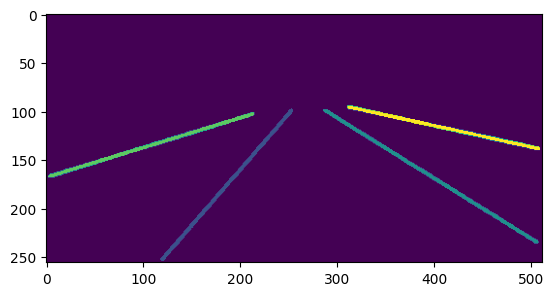

In [10]:
plt.imshow(ins.squeeze())

To obtain the instance segmentation we should train the embeddings as we described in the project description. In order to do that we need to implement [Discriminative Loss](https://arxiv.org/pdf/1708.02551.pdf). Discriminative loss consists of three parts:

1. Inter-cluster push-force: cluster means should be far away from each other
2. Intra-cluster pull-force: embeddings should be close to the center of the corresponding cluster.
3. Regularization: cluster centers should be close to zero.

Corresponding weights for the losses and other hyper-parameters could be found in the paper.

In [11]:
class DiscriminativeLoss(_Loss):
    def __init__(self, delta_var=0.5, delta_dist=3,
                 norm=2, alpha=1.0, beta=1.0, gamma=0.001,
                 device="cpu", reduction="mean", n_clusters=4):
        super(DiscriminativeLoss, self).__init__(reduction=reduction)
        self.delta_var = delta_var
        self.delta_dist = delta_dist
        self.norm = norm
        self.alpha = alpha
        self.beta = beta
        self.gamma = gamma
        self.device = torch.device(device)
        self.n_clusters = n_clusters
        assert self.norm in [1, 2]

    def forward(self, input, target):
        assert not target.requires_grad

        return self._discriminative_loss(input, target)

    def _discriminative_loss(self, input, target):
        num_samples=target.size(0)

        dis_loss=torch.tensor(0.).to(self.device)
        var_loss=torch.tensor(0.).to(self.device)
        reg_loss=torch.tensor(0.).to(self.device)
        for i in range(num_samples):
            clusters=[]
            sample_embedding=input[i,:,:,:]
            sample_label=target[i,:,:].squeeze()
            num_clusters=len(sample_label.unique())-1
            vals=sample_label.unique()[1:]
            sample_label=sample_label.view(sample_label.size(0)*sample_label.size(1))
            sample_embedding=sample_embedding.view(-1,sample_embedding.size(1)*sample_embedding.size(2))
            v_loss=torch.tensor(0.).to(self.device)
            d_loss=torch.tensor(0.).to(self.device)
            r_loss=torch.tensor(0.).to(self.device)
            for j in range(num_clusters):
                indices=(sample_label==vals[j]).nonzero()
                indices=indices.squeeze()
                cluster_elements=torch.index_select(sample_embedding,1,indices)
                Nc=cluster_elements.size(1)
                mean_cluster=cluster_elements.mean(dim=1,keepdim=True)
                clusters.append(mean_cluster)
                v_loss+=torch.pow((torch.clamp(torch.norm(cluster_elements-mean_cluster)-self.delta_var,min=0.)),2).sum()/Nc
                r_loss+=torch.sum(torch.abs(mean_cluster))
            for index in range(num_clusters):
                for idx,cluster in enumerate(clusters):
                    if index==idx:
                        continue 
                    else:
                        distance=torch.norm(clusters[index]-cluster)#torch.sqrt(torch.sum(torch.pow(clusters[index]-cluster,2)))
                        d_loss+=torch.pow(torch.clamp(self.delta_dist-distance,min=0.),2)
            var_loss+=v_loss/num_clusters
            dis_loss+=d_loss/(num_clusters*(num_clusters-1))
            reg_loss+=r_loss/num_clusters
        return self.alpha*(var_loss/num_samples)+self.beta*(dis_loss/num_samples)+self.gamma*(reg_loss/num_samples)

Test the loss.

In [12]:
DiscriminativeLoss(delta_var=0.5, delta_dist=3, alpha=1.0, beta=1.0, gamma=0.001)(ins_pred, ins)

tensor(9.8827, grad_fn=<AddBackward0>)

A helper function to compute two losses.

In [13]:
def compute_loss(binary_output, instance_output, binary_label, instance_label):
    ce_loss = nn.CrossEntropyLoss()
    binary_loss = ce_loss(binary_output, binary_label)

    ds_loss = DiscriminativeLoss(delta_var=0.5, delta_dist=3, alpha=1.0, beta=1.0, gamma=0.001, device="cpu")
    instance_loss = ds_loss(instance_output, instance_label)
    
    return binary_loss, instance_loss

Now we are ready to train the network. You may want to create validation subset to track metrics.

In [14]:
# Display information about the NVIDIA GPUs using the nvidia-smi command for the project
!nvidia-smi


Mon Mar 11 23:50:43 2024       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 527.37       Driver Version: 527.37       CUDA Version: 12.0     |
|-------------------------------+----------------------+----------------------+
| GPU  Name            TCC/WDDM | Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  NVIDIA GeForce ... WDDM  | 00000000:01:00.0 Off |                  N/A |
| N/A   50C    P8     7W /  N/A |      0MiB /  4096MiB |      0%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

In [15]:
# import tqdm


# BATCH_SIZE = 8
# LR = 5e-4
# NUM_EPOCHS = 20

# train_dataset = LaneDataset()
# train_dataloader = torch.utils.data.DataLoader(train_dataset, batch_size=BATCH_SIZE, shuffle=False)
# device = torch.device("cuda") if torch.cuda.is_available() else torch.device("cpu")

# enet_model = ENet(2, 4)
# enet_model.to(device)

# params = [p for p in enet_model.parameters() if p.requires_grad]
# optimizer = torch.optim.Adam(params, lr=LR, weight_decay=0.0002)

# train_losses = []

# for epoch in range(NUM_EPOCHS):
#     enet_model.train()
#     losses = []
#     for batch in tqdm.tqdm(train_dataloader):
#         img, binary_target, instance_target = batch
#         img = img.to(device)
#         binary_target = binary_target.to(device)
#         instance_target = instance_target.to(device)

#         optimizer.zero_grad()

#         binary_logits, instance_emb = enet_model(img)

#         binary_loss, instance_loss = compute_loss(binary_logits, instance_emb, binary_target, instance_target)
#         loss = binary_loss + instance_loss
#         loss.backward()

#         optimizer.step()
        
#         losses.append((binary_loss.detach().cpu(), instance_loss.detach().cpu()))
    
#     mean_losses = np.array(losses).mean(axis=0)

#     msg = (f"Epoch {epoch}:"
#           f"loss = {mean_losses}")
#     print(msg)

In [16]:
import tqdm
import numpy as np
import torch
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score

# Assuming the definitions of LaneDataset, ENet, compute_loss, etc., are provided elsewhere

BATCH_SIZE = 8
LR = 5e-4
NUM_EPOCHS = 20

train_dataset = LaneDataset()  # Your training dataset
train_dataloader = torch.utils.data.DataLoader(train_dataset, batch_size=BATCH_SIZE, shuffle=True)

# Similarly, initialize your validation dataset here
validation_dataset = LaneDataset()  # Replace with actual code to initialize your validation dataset
validation_dataloader = torch.utils.data.DataLoader(validation_dataset, batch_size=BATCH_SIZE, shuffle=False)

device = torch.device("cpu")

enet_model = ENet(2, 4)
enet_model.to(device)

optimizer = torch.optim.Adam(enet_model.parameters(), lr=LR, weight_decay=0.0002)

def evaluate_model(model, dataloader):
    model.eval()
    total_loss = 0
    all_binary_targets, all_binary_predictions = [], []
    
    with torch.no_grad():
        for img, binary_target, instance_target in dataloader:
            img, binary_target, instance_target = img.to(device), binary_target.to(device), instance_target.to(device)
            binary_logits, instance_emb = model(img)
            binary_loss, instance_loss = compute_loss(binary_logits, instance_emb, binary_target, instance_target)
            total_loss += binary_loss.item() + instance_loss.item()
            
            binary_predictions = torch.argmax(binary_logits, dim=1).flatten()
            all_binary_targets.append(binary_target.cpu().numpy().flatten())
            all_binary_predictions.append(binary_predictions.cpu().numpy().flatten())

    all_binary_targets = np.concatenate(all_binary_targets)
    all_binary_predictions = np.concatenate(all_binary_predictions)
    
    # Debugging: Check shapes and unique values
    print(f"Targets shape: {all_binary_targets.shape}, unique values: {np.unique(all_binary_targets)}")
    print(f"Predictions shape: {all_binary_predictions.shape}, unique values: {np.unique(all_binary_predictions)}")
    
    accuracy = accuracy_score(all_binary_targets, all_binary_predictions)
    precision = precision_score(all_binary_targets, all_binary_predictions, average='macro', zero_division=0)
    recall = recall_score(all_binary_targets, all_binary_predictions, average='macro', zero_division=0)
    f1 = f1_score(all_binary_targets, all_binary_predictions, average='macro', zero_division=0)
    
    return total_loss / len(dataloader), accuracy, precision, recall, f1

for epoch in range(NUM_EPOCHS):
    enet_model.train()
    train_loss = 0
    for img, binary_target, instance_target in tqdm.tqdm(train_dataloader):
        img, binary_target, instance_target = img.to(device), binary_target.to(device), instance_target.to(device)
        
        optimizer.zero_grad()
        binary_logits, instance_emb = enet_model(img)
        binary_loss, instance_loss = compute_loss(binary_logits, instance_emb, binary_target, instance_target)
        loss = binary_loss + instance_loss
        loss.backward()
        optimizer.step()
        
        train_loss += loss.item()

    train_loss /= len(train_dataloader)
    val_loss, accuracy, precision, recall, f1 = evaluate_model(enet_model, validation_dataloader)
    print(f"Epoch {epoch}: Train loss = {train_loss:.4f}, Val loss = {val_loss:.4f}, Accuracy = {accuracy:.4f}, Precision = {precision:.4f}, Recall = {recall:.4f}, F1 = {f1:.4f}")


100%|██████████| 402/402 [24:11<00:00,  3.61s/it]


Targets shape: (421527552,), unique values: [0 1]
Predictions shape: (421527552,), unique values: [0 1]
Epoch 0: Train loss = 2.3972, Val loss = 0.4632, Accuracy = 0.9748, Precision = 0.8056, Recall = 0.5790, F1 = 0.6218


100%|██████████| 402/402 [30:51<00:00,  4.60s/it]


Targets shape: (421527552,), unique values: [0 1]
Predictions shape: (421527552,), unique values: [0 1]
Epoch 1: Train loss = 0.4713, Val loss = 0.2853, Accuracy = 0.9783, Precision = 0.8299, Recall = 0.6861, F1 = 0.7367


100%|██████████| 402/402 [18:04<00:00,  2.70s/it]


Targets shape: (421527552,), unique values: [0 1]
Predictions shape: (421527552,), unique values: [0 1]
Epoch 2: Train loss = 0.3527, Val loss = 0.2359, Accuracy = 0.9799, Precision = 0.8376, Recall = 0.7311, F1 = 0.7737


100%|██████████| 402/402 [17:41<00:00,  2.64s/it]


Targets shape: (421527552,), unique values: [0 1]
Predictions shape: (421527552,), unique values: [0 1]
Epoch 3: Train loss = 0.2945, Val loss = 0.2224, Accuracy = 0.9807, Precision = 0.8283, Recall = 0.7802, F1 = 0.8022


100%|██████████| 402/402 [30:48<00:00,  4.60s/it]


Targets shape: (421527552,), unique values: [0 1]
Predictions shape: (421527552,), unique values: [0 1]
Epoch 4: Train loss = 0.2520, Val loss = 0.1905, Accuracy = 0.9813, Precision = 0.8457, Recall = 0.7630, F1 = 0.7984


100%|██████████| 402/402 [23:36<00:00,  3.52s/it]


Targets shape: (421527552,), unique values: [0 1]
Predictions shape: (421527552,), unique values: [0 1]
Epoch 5: Train loss = 0.2273, Val loss = 0.1571, Accuracy = 0.9818, Precision = 0.8436, Recall = 0.7856, F1 = 0.8117


100%|██████████| 402/402 [18:57<00:00,  2.83s/it]


Targets shape: (421527552,), unique values: [0 1]
Predictions shape: (421527552,), unique values: [0 1]
Epoch 6: Train loss = 0.2170, Val loss = 0.1496, Accuracy = 0.9816, Precision = 0.8516, Recall = 0.7607, F1 = 0.7990


100%|██████████| 402/402 [26:11<00:00,  3.91s/it]


Targets shape: (421527552,), unique values: [0 1]
Predictions shape: (421527552,), unique values: [0 1]
Epoch 7: Train loss = 0.1812, Val loss = 0.1437, Accuracy = 0.9816, Precision = 0.8352, Recall = 0.7970, F1 = 0.8149


100%|██████████| 402/402 [17:40<00:00,  2.64s/it]


Targets shape: (421527552,), unique values: [0 1]
Predictions shape: (421527552,), unique values: [0 1]
Epoch 8: Train loss = 0.1791, Val loss = 0.1224, Accuracy = 0.9819, Precision = 0.8500, Recall = 0.7736, F1 = 0.8068


100%|██████████| 402/402 [15:49<00:00,  2.36s/it]


Targets shape: (421527552,), unique values: [0 1]
Predictions shape: (421527552,), unique values: [0 1]
Epoch 9: Train loss = 0.1578, Val loss = 0.1401, Accuracy = 0.9819, Precision = 0.8488, Recall = 0.7768, F1 = 0.8084


100%|██████████| 402/402 [17:37<00:00,  2.63s/it]


Targets shape: (421527552,), unique values: [0 1]
Predictions shape: (421527552,), unique values: [0 1]
Epoch 10: Train loss = 0.1453, Val loss = 0.1163, Accuracy = 0.9828, Precision = 0.8491, Recall = 0.8045, F1 = 0.8252


100%|██████████| 402/402 [15:59<00:00,  2.39s/it]


Targets shape: (421527552,), unique values: [0 1]
Predictions shape: (421527552,), unique values: [0 1]
Epoch 11: Train loss = 0.1542, Val loss = 0.1041, Accuracy = 0.9821, Precision = 0.8514, Recall = 0.7786, F1 = 0.8105


100%|██████████| 402/402 [16:56<00:00,  2.53s/it]


Targets shape: (421527552,), unique values: [0 1]
Predictions shape: (421527552,), unique values: [0 1]
Epoch 12: Train loss = 0.1590, Val loss = 0.1081, Accuracy = 0.9825, Precision = 0.8518, Recall = 0.7905, F1 = 0.8181


100%|██████████| 402/402 [16:36<00:00,  2.48s/it]


Targets shape: (421527552,), unique values: [0 1]
Predictions shape: (421527552,), unique values: [0 1]
Epoch 13: Train loss = 0.1614, Val loss = 0.1315, Accuracy = 0.9818, Precision = 0.8434, Recall = 0.7832, F1 = 0.8102


100%|██████████| 402/402 [16:13<00:00,  2.42s/it]


Targets shape: (421527552,), unique values: [0 1]
Predictions shape: (421527552,), unique values: [0 1]
Epoch 14: Train loss = 0.1494, Val loss = 0.1236, Accuracy = 0.9823, Precision = 0.8434, Recall = 0.8030, F1 = 0.8218


100%|██████████| 402/402 [16:15<00:00,  2.43s/it]


Targets shape: (421527552,), unique values: [0 1]
Predictions shape: (421527552,), unique values: [0 1]
Epoch 15: Train loss = 0.1547, Val loss = 0.0968, Accuracy = 0.9827, Precision = 0.8546, Recall = 0.7924, F1 = 0.8203


100%|██████████| 402/402 [16:14<00:00,  2.42s/it]


Targets shape: (421527552,), unique values: [0 1]
Predictions shape: (421527552,), unique values: [0 1]
Epoch 16: Train loss = 0.1289, Val loss = 0.0997, Accuracy = 0.9828, Precision = 0.8598, Recall = 0.7847, F1 = 0.8176


100%|██████████| 402/402 [17:59<00:00,  2.69s/it]


Targets shape: (421527552,), unique values: [0 1]
Predictions shape: (421527552,), unique values: [0 1]
Epoch 17: Train loss = 0.1298, Val loss = 0.0952, Accuracy = 0.9831, Precision = 0.8586, Recall = 0.7968, F1 = 0.8246


100%|██████████| 402/402 [19:30<00:00,  2.91s/it]


Targets shape: (421527552,), unique values: [0 1]
Predictions shape: (421527552,), unique values: [0 1]
Epoch 18: Train loss = 0.1222, Val loss = 0.1047, Accuracy = 0.9830, Precision = 0.8527, Recall = 0.8049, F1 = 0.8269


100%|██████████| 402/402 [46:36<00:00,  6.96s/it]   


Targets shape: (421527552,), unique values: [0 1]
Predictions shape: (421527552,), unique values: [0 1]
Epoch 19: Train loss = 0.1125, Val loss = 0.0970, Accuracy = 0.9834, Precision = 0.8500, Recall = 0.8225, F1 = 0.8357


In [17]:
enet_eval_dataset = LaneDataset(train=False)
enet_eval_img_1, *_ = enet_eval_dataset[0]
enet_eval_img_1 = enet_eval_img_1.to(device)

binary_logits, instance_emb = enet_model(enet_eval_img_1[None, ...])

In [18]:
enet_eval_img_1.shape, binary_logits.shape, instance_emb.shape

(torch.Size([1, 256, 512]),
 torch.Size([1, 2, 256, 512]),
 torch.Size([1, 4, 256, 512]))

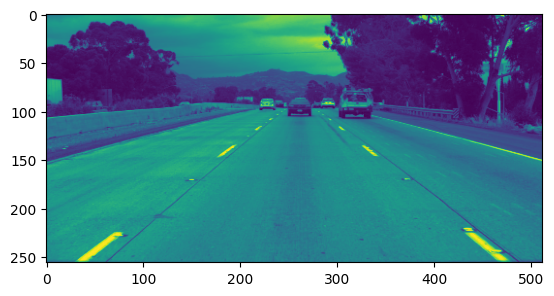

In [19]:
plt.imshow(enet_eval_img_1.squeeze().cpu())

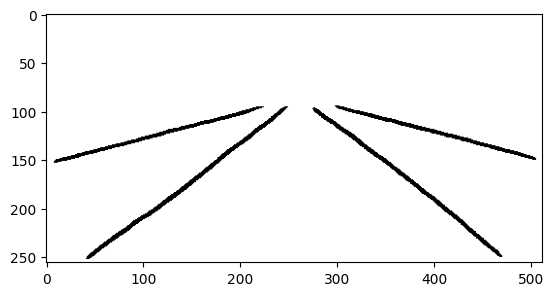

In [20]:
plt.imshow(binary_logits.squeeze().argmax(axis=0).cpu(), cmap=plt.cm.binary)

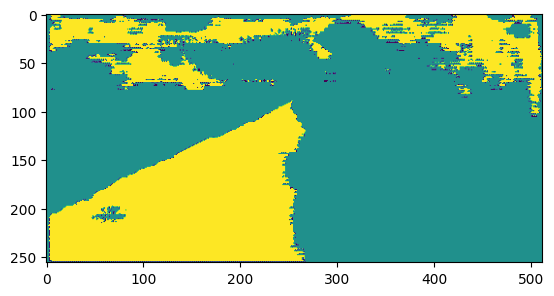

In [21]:
plt.imshow(instance_emb.squeeze()[0:3, :, :].argmax(axis=0).cpu())

## Homograpy Prediction Code

Here we again need to implement the Dataset class. Dataset class should return resized image and ground truth points for the lane trajectories.


In [22]:
class HomographyPredictionDataset(torch.utils.data.Dataset):
    def __init__(self, dataset_path="./train_set", train=True, size=(128, 64)):
        self.dataset_path = dataset_path
        self.train = train
        self.size = size
        self.image_list = []
        self.lanes_list = []
        self.max_lanes = 0
        self.max_points = 0

        assert os.path.exists(self.dataset_path), f'Directory {self.dataset_path} does not exist!'

        label_files = []
        if self.train:
            label_files.append(os.path.join(self.dataset_path, 'label_data_0313.json'))
            label_files.append(os.path.join(self.dataset_path, 'label_data_0531.json'))
        else:
            label_files.append(os.path.join(self.dataset_path, 'label_data_0601.json'))

        for file in label_files:
            try:
                for line in open(file).readlines():
                    info_dict = json.loads(line)
                    self.image_list.append(info_dict['raw_file'])
                    h_samples = info_dict['h_samples']
                    lanes = info_dict['lanes']
                    self.max_lanes = max(self.max_lanes, len(lanes))
                    xy_list = []

                    for lane in lanes:
                        y = np.array([h_samples], dtype=np.float64).T
                        x = np.array([lane], dtype=np.float64).T
                        xy = np.hstack((x, y))
                        index = np.where(xy[:, 0] > 2)
                        xy_list.append(xy[index])
                        self.max_points = max(self.max_points, len(xy[index]))
                    self.lanes_list.append(xy_list)
            except BaseException:
                raise Exception(f'Fail to load {file}')

    def __getitem__(self, idx):
        img_path = os.path.join(self.dataset_path, self.image_list[idx])

        image = cv2.imread(img_path, cv2.IMREAD_COLOR)
        original_height, original_width, _ = image.shape
        image = cv2.resize(image, self.size, interpolation=cv2.INTER_LINEAR)

        image = np.transpose(image, (2, 0, 1))
        image = torch.from_numpy(image).float() / 255

        # creating output with shape [max_lanes, 2, max_points]
        buffer = None

        for lane in self.lanes_list[idx]:
            lane = np.expand_dims(np.pad(np.swapaxes(lane, 0, 1),
                                         pad_width=((0, 0), (0, self.max_points - lane.shape[0])),
                                         mode='constant',
                                         constant_values=0), 0)

            if buffer is not None:
                buffer = np.concatenate((buffer, lane), 0)
            else:
                buffer = lane
        
        # Scale lane coords
        buffer[:, 0, :] /= original_width
        buffer[:, 0, :] *= self.size[0]
        buffer[:, 1, :] /= original_height
        buffer[:, 1, :] *= self.size[1]
        
        ground_truth_trajectory = torch.from_numpy(np.pad(buffer,
                                                          pad_width=((0, self.max_lanes - buffer.shape[0]),
                                                                     (0, 0),
                                                                     (0, 0)),
                                                          mode='constant',
                                                          constant_values=0))
        


        return image, ground_truth_trajectory

    def __len__(self):
        return len(self.image_list)

In [23]:
homography_ds = HomographyPredictionDataset()

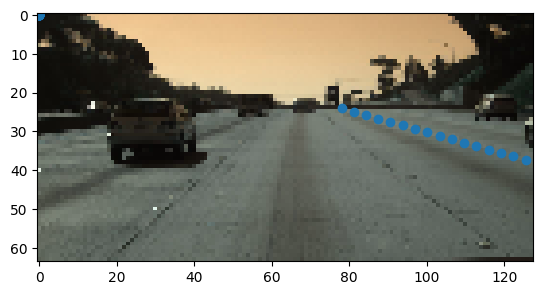

In [24]:
plt.imshow(homography_ds[1][0].permute(1, 2, 0))
plt.scatter(x=homography_ds[1][1][3][0], y=homography_ds[1][1][3][1])

Now we need to implement the H-Net. It should return homography matrix that is parametrized by 6 numbers [LaneNet paper](https://arxiv.org/pdf/1802.05591.pdf).

We suggest to follow the paper and take 64x128 image as in input.

Homography projection contains discontinuities, therefore it could be quite difficult to train the network. In order to simplify the problem we propose not to train the homography from scratch, but train some correction to a good starting point.

The following code block contains the initial homography that can be used.


In [25]:
import torch

# important note: this homography matrix is suitable only for 64x128 resolution
R = torch.Tensor([[-2.0484e-01, -1.7122e+01,  3.7991e+02],
                  [ 0.0000e+00, -1.6969e+01,  3.7068e+02],
                  [ 0.0000e+00, -4.6739e-02,  1.0000e+00]])

Let's check the effect of this homography on the image.

In [26]:
# !wget https://miro.medium.com/max/2560/1*b3HiwPg69Rw0L5iIMQMXOw.jpeg

In [27]:
from matplotlib import pyplot as plt
import cv2

In [28]:
image = plt.imread('b3HiwPg69Rw0L5iIMQMXOw.jpeg')

In [29]:
image = cv2.resize(image, (128, 64))

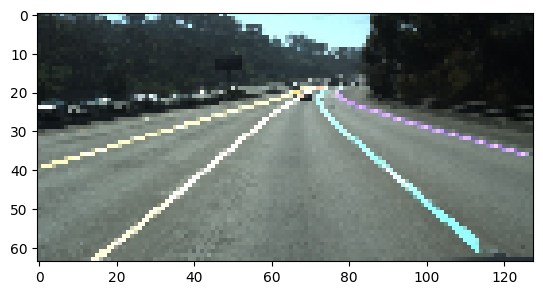

In [30]:
plt.imshow(image)

In [31]:
R_np = R.numpy()

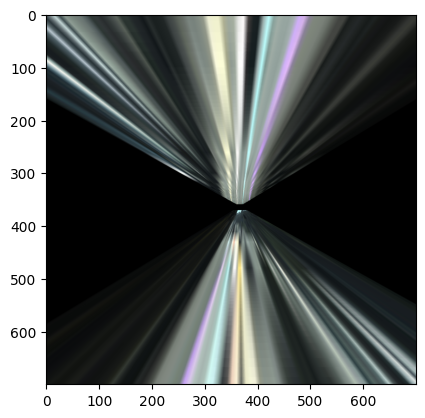

In [32]:
plt.imshow(cv2.warpPerspective(image, R_np, dsize=(700, 700)))

As you can see it looks like a bird's eye view projection where lines are becoming parallel.

In [33]:
class HNet(nn.Module):
    def __init__(self):
        super(HNet, self).__init__()
        self.conv1 = nn.Conv2d(3, 16, 3, stride=1, padding=1)
        self.bn1 = nn.BatchNorm2d(16)

        self.conv2 = nn.Conv2d(16, 16, 3, stride=1, padding=1)
        self.bn2 = nn.BatchNorm2d(16)

        self.conv3 = nn.Conv2d(16, 32, 3, stride=1, padding=1)
        self.bn3 = nn.BatchNorm2d(32)

        self.conv4 = nn.Conv2d(32, 32, 3, stride=1, padding=1)
        self.bn4 = nn.BatchNorm2d(32)

        self.conv5 = nn.Conv2d(32, 64, 3, stride=1, padding=1)
        self.bn5 = nn.BatchNorm2d(64)

        self.conv6 = nn.Conv2d(64, 64, 3, stride=1, padding=1)
        self.bn6 = nn.BatchNorm2d(64)

        self.ln1 = nn.Linear(8192, 1024)
        self.bn7 = nn.BatchNorm1d(1024)
        
        self.ln2 = nn.Linear(1024, 6)       
    
        self.relu = nn.ReLU(inplace=True)
        self.maxpool = nn.MaxPool2d(2, stride=2)


    def forward(self, x):
        x = self.conv1(x)
        x = self.relu(self.bn1(x))
        x = self.conv2(x)
        x = self.relu(self.bn2(x))
        x = self.maxpool(x)

        x = self.conv3(x)
        x = self.relu(self.bn3(x))
        x = self.conv4(x)
        x = self.relu(self.bn4(x))
        x = self.maxpool(x)

        x = self.conv5(x)
        x = self.relu(self.bn5(x))
        x = self.conv6(x)
        x = self.relu(self.bn6(x))
        x = self.maxpool(x)
        
        x = x.view(x.size(0), -1)
        x = self.ln1(x)
        x = self.relu(self.bn7(x))
        x = self.ln2(x)        
        
        return x

In [34]:
class HomographyLoss(torch.nn.modules.loss._Loss):
    def __init__(self, reduction="mean", order=2, device="cpu"):
        super(HomographyLoss, self).__init__(reduction=reduction)
        self._device = device
        self._order = order
        self._R = torch.tensor(
            [[-2.0484e-01, -1.7122e+01,  3.7991e+02],
             [ 0.0000e+00, -1.6969e+01,  3.7068e+02],
             [ 0.0000e+00, -4.6739e-02,  1.0000e+00]],
            dtype=torch.float32, device=device
        )

    def forward(self, inputs, targets):
        assert inputs.shape[0] == targets.shape[0], ("Number of items in batch for inputs and targets must be the same, "
         + f"got N_inputs={inputs.shape[0]}, N_targets={targets.shape[0]}")
        losses = []
        for correction, gt_lanes in zip(inputs, targets):
            #print(correction, gt_lanes)
            for lane in gt_lanes:
                if lane.sum() == 0:
                    continue
                    
                lane_loss = self.compute_loss_for_lane(correction, lane)
                if lane_loss is None:
                    continue
                    
                losses.append(lane_loss)

        return torch.stack(losses).mean()
    
    def compute_loss_for_lane(self, correction, lane):
        H_correction_indices = [0, 1, 2, 4, 5, 7]
        H_correction = correction.flatten()
        H = self._R.flatten().clone()
        H[H_correction_indices] = H_correction
        H = H.reshape((3, 3))
        
        points = lane.T
        #print(points)
        #print(points, points.nonzero())
        index = points.nonzero().flatten().max().item() + 1
        #print(index)
        points = points[:index, :]
        ones_col = torch.ones(points.shape[0], device=device)
        P = torch.column_stack((points, ones_col)).T.to(torch.float32)
        P_transformed = H @ P
        
        x_transformed = P_transformed[0, :].T # N×1
        y_transformed_squares = P_transformed[1, :] ** 2
        y_transformed = P_transformed[1, :]
        Y = torch.column_stack((y_transformed_squares, y_transformed, ones_col)) # N×3
        #print((Y.T @ Y).isnan().sum())
        w = torch.linalg.solve(Y.T @ Y, Y.T) @ x_transformed # 3×N @ N×3 @ 3×N @ N×1 = 3×1
        
        x_predicted = Y @ w # N×3 @ 3×1 = N×1
        P_predicted = torch.column_stack((x_predicted, y_transformed, ones_col)).T # 3×N
        P_reprojected = torch.linalg.inv(H.detach()) @ P_predicted # 3×3 @ 3×N = 3×N
        
        P_reprojected = torch.div(P_reprojected, P_reprojected[2, :])
        
        #print(points[:, 0].T.shape, P_reprojected[0, :].shape)
        #print(P_reprojected)
        
        loss = ((points[:, 0].T - P_reprojected[0, :]) ** 2).mean()
        
        return loss            

Test HNet.

In [35]:
hnet = HNet()
batch = torch.stack((homography_ds[0][0], homography_ds[1][0]))
predicted_corrections = hnet(batch)

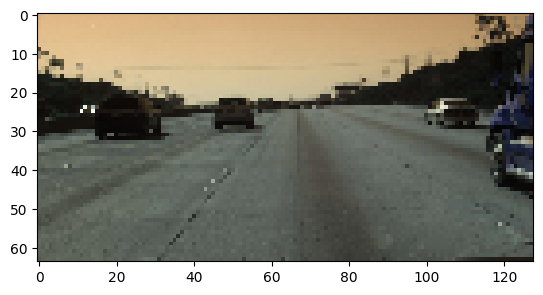

In [36]:
plt.imshow(homography_ds[0][0].permute(1, 2, 0))

In [37]:
R_corrected_test_image_1 = torch.tensor(
    [
        [R[0, 0] + predicted_corrections[0][0], R[0, 1] + predicted_corrections[0][1], R[0, 2] + predicted_corrections[0][2]],
        [R[1, 0], R[1, 1] + predicted_corrections[0][3], R[1, 2] + predicted_corrections[0][4]],
        [R[2, 0], R[2, 1] + predicted_corrections[0][5], R[2, 2]],
    ]
)
R_corrected_test_image_1

tensor([[ -0.5851, -17.5301, 380.3178],
        [  0.0000, -17.0754, 370.6486],
        [  0.0000,   0.4377,   1.0000]])

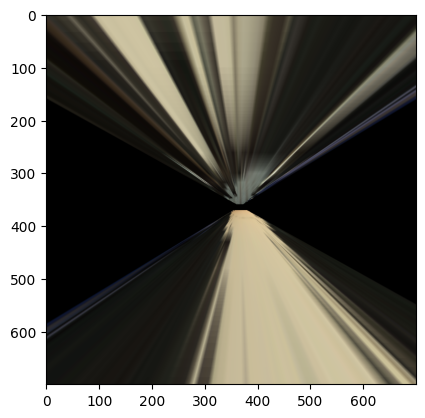

In [38]:
plt.imshow(cv2.warpPerspective(homography_ds[0][0].permute(1, 2, 0).numpy(), R_np, dsize=(700, 700)))

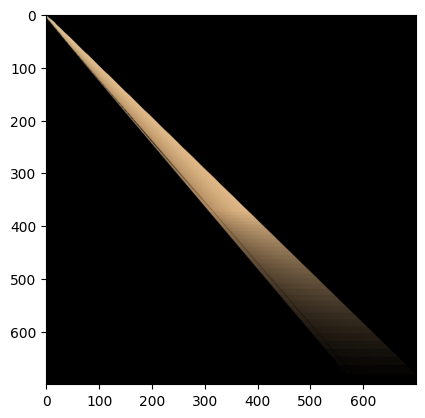

In [39]:
plt.imshow(cv2.warpPerspective(homography_ds[0][0].permute(1, 2, 0).numpy(), R_corrected_test_image_1.numpy(), dsize=(700, 700)))

In [40]:
torch.autograd.set_detect_anomaly(True)

Finally, train the homography net with the 2-nd order polynomial fitting (you can 3-rd order but we found out that it is much easier to train h-net with the 2-nd order polynomials).

We found out that SGD fits much better for this architectures. Adam (and momentums inside) can ruin the weights because of the discontinuities in the target function surface.

Demonstrate the difference in homography loss between h-net and provided fixed homography on the validation samples.

In [41]:
# Train the H-Net
BATCH_SIZE = 10
LR = 5e-5
NUM_EPOCHS = 20

hnet_train_dataset = HomographyPredictionDataset()
hnet_train_dataloader = torch.utils.data.DataLoader(hnet_train_dataset, batch_size=BATCH_SIZE, shuffle=False)
device = torch.device("cpu")

hnet_model = HNet()
hnet_model.to(device)

params = [p for p in hnet_model.parameters() if p.requires_grad]
optimizer = torch.optim.SGD(params, lr=LR)

criterion = HomographyLoss(device=device)

for epoch in range(NUM_EPOCHS):
    hnet_model.train()
    losses = []
    for inputs, points in tqdm.tqdm(hnet_train_dataloader, leave=False):
        inputs = inputs.to(device)
        points = points.to(device)    
        
        coefs = hnet_model(inputs)
        loss = criterion(coefs, points)
        
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        
        losses.append(loss.detach().cpu().numpy())
        
    epoch_loss = np.array(losses).mean()
    
    print(f"Epoch {epoch}, loss = {epoch_loss}")
    

  0%|          | 0/322 [00:00<?, ?it/s]C:\Users\musev\AppData\Local\Temp\ipykernel_10060\1535083062.py:48: UserWarning: The use of `x.T` on tensors of dimension other than 2 to reverse their shape is deprecated and it will throw an error in a future release. Consider `x.mT` to transpose batches of matrices or `x.permute(*torch.arange(x.ndim - 1, -1, -1))` to reverse the dimensions of a tensor. (Triggered internally at ..\aten\src\ATen\native\TensorShape.cpp:3641.)
  x_transformed = P_transformed[0, :].T # N×1


Epoch 0, loss = 77204.82091202418


Epoch 1, loss = 5572.960181197706


Epoch 2, loss = 5537.256860063085


Epoch 3, loss = 5533.754850922845


Epoch 4, loss = 5533.909979681296


Epoch 5, loss = 5534.058538230966


Epoch 6, loss = 5534.233199997621


Epoch 7, loss = 5534.4739373801085


Epoch 8, loss = 5534.779478641458


Epoch 9, loss = 5534.919937147877


Epoch 10, loss = 5534.858893464367


Epoch 11, loss = 5534.868326504456


Epoch 12, loss = 5534.855130249843


Epoch 13, loss = 5534.857059430186


Epoch 14, loss = 5534.856135487297


Epoch 15, loss = 5534.851734256271


Epoch 16, loss = 5534.859847287


Epoch 17, loss = 5534.842293334002


Epoch 18, loss = 5534.8562418089805


Epoch 19, loss = 5534.843826946023


# Complete Pipeline

Now you need to implement a class that takes image and a set of $y$ coordinates as an input and returns the $x$ coordinate for each lane in this image.

It should contain the following steps:

1. Apply segmentation network to the image
2. Run DBSCAN over the embeddings for those pixels that are lanes.
3. Apply h-net to the image
4. Project pixel coordinates with the predicted homograpgy
5. Fit the 3-rd order polynomial
6. Predict the lane position for each provided $y$ (you should project this first).
7. Compute back projection and return the positions of $x$ for each lane.

Note: if you weren't able to train the H-Net, you can use the fixed homography here.

In [42]:
class LaneDetector:
    DEFAULT_IMAGE_SIZE = (512, 256)
    
    def __init__(self, enet, hnet=None, device="cpu", with_projection=False):
        self._enet = enet
        self._hnet = hnet
        self._default_homography = torch.tensor(
            [[-2.0484e-01, -1.7122e+01,  3.7991e+02],
             [ 0.0000e+00, -1.6969e+01,  3.7068e+02],
             [ 0.0000e+00, -4.6739e-02,  1.0000e+00]],
            dtype=torch.float32, device=device
        )
        self._eps = 1.0
        self._device = device
        self._with_projection = with_projection
  
    def __call__(self, image, y_positions=None):
        image = self._preprocess_image(image)
        if y_positions is None:
            y_positions = np.linspace(50, image.shape[2], 30)
        #print(image.shape)
        binary_logits, instance_embeddings = self._enet(image)
        segmentation_map = binary_logits.squeeze().argmax(dim=0)
        instances_map = self._cluster(segmentation_map, instance_embeddings)
        lanes = self._extract_lanes(instances_map)
        print(f"Detected {len(lanes)} lanes")
        #print(lanes)
        if self._with_projection:
            projected_lanes = self._project_lanes(lanes)
            #print(projected_lanes)
            coefs = self._fit(projected_lanes)
            #print(lanes[0])
            #print(projected_lanes[0])
            print(coefs)
            y_positions_projected = self._project_y(y_positions)
            #print(y_positions_projected)
            fitted_lanes = self._predict_lanes(coefs, y_positions_projected)
            #print(fitted_lanes)        
            reprojected_lanes = self._reproject(fitted_lanes)
            #print(reprojected_lanes)
            predicted_lanes = reprojected_lanes
        else:
            coefs = self._fit(lanes)
            #print(coefs)
            fitted_lanes = self._predict_lanes(coefs, y_positions)
            predicted_lanes = fitted_lanes
        
        predicted_lanes = self._postprocess_result(predicted_lanes)
        
        return instances_map.cpu().numpy(), predicted_lanes.cpu().numpy()
    
    def _cluster(self, segmentation_map, instance_embeddings):
        segmentation_map = segmentation_map.flatten()
        #print(segmentation_map.shape)
        instance_embeddings = instance_embeddings.squeeze().permute(1, 2, 0).reshape(segmentation_map.shape[0], -1)
        #print(instance_embeddings.shape)
        #print(instance_embeddings[:5, :])
        assert segmentation_map.shape[0] == instance_embeddings.shape[0]
        
        mask_indices = segmentation_map.nonzero().flatten()
        #print(mask_indices.shape)
        cluster_data = instance_embeddings[mask_indices].detach().cpu()
        #print(cluster_data.shape)       
        
        clusterer = DBSCAN(eps=self._eps)
        labels = clusterer.fit_predict(cluster_data)
        labels = torch.tensor(labels, dtype=instance_embeddings.dtype, device=self._device)
        #print(labels.unique())
        
        instances_map = torch.zeros(instance_embeddings.shape[0], dtype=instance_embeddings.dtype, device=self._device)
        instances_map[mask_indices] = labels
        instances_map = instances_map.reshape(self.DEFAULT_IMAGE_SIZE[::-1])
        #print(instances_map.shape)
        
        return instances_map
    
    def _extract_lanes(self, instances_map, scale=False):
        lanes = []
        lane_indices = instances_map.unique()[1:]
        #print(lane_indices)
        for index in lane_indices:
            coords = (instances_map == index).nonzero(as_tuple=True)
            if scale:
                coords = [c / 4 for c in coords]
            coords = coords[::-1] # from (y, x) to (x, y)
            coords = torch.stack(coords).to(instances_map.dtype)
            lanes.append(coords)
        
        return lanes         
    
    def _fit(self, lanes):
        coefs = []
        #print(len(lanes))
        for lane in lanes:
            x = lane[0, :].unsqueeze(dim=1)
            y = lane[1, :]
            Y = torch.stack((y, torch.ones(y.shape[0], device=self._device))).T
            #print(x.shape, Y.shape)
            w = torch.linalg.inv(Y.T @ Y) @ Y.T @ x
            coefs.append(w)
            
        return coefs

    def _postprocess_result(self, lanes):
        processed = []
        for i, lane in enumerate(lanes):
            lane = lane.T
            lane[:, 2] = i
            ind1 = lane[:, 0] >= 0
            ind2 = lane[:, 0] <= 512
            index = torch.logical_and(ind1, ind2)
            lane = lane[index, :]
            processed.append(lane)
        
        return torch.cat(processed, dim=0)
    
    def _predict_lanes(self, coefs, y_positions):
        lanes = []
        
        for coef in coefs:
            c, d = coef
            lane = []
            for y in y_positions:
                x = c * y + d
                lane.append((x, y, 1))
            lanes.append(torch.tensor(lane, device=self._device).T)
        
        return lanes                
    
    def _preprocess_image(self, image):
        image = cv2.resize(image, self.DEFAULT_IMAGE_SIZE, interpolation=cv2.INTER_LINEAR)
        image = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
        image = image[..., None]
        image = torch.from_numpy(image).float().permute((2, 0, 1)).unsqueeze(dim=0).to(device)
        
        return image

    def _project_lanes(self, lanes):
        projected = []
        for lane in lanes:
            ones = torch.ones((1, lane.shape[1]), device=self._device)
            P = torch.cat((lane, ones), dim=0)
            #print(P)
            P_projected = self._default_homography @ P
            
            P_projected = P_projected / P_projected[2, :]
            #print(P_projected)
            projected.append(P_projected)
        
        return projected
    
    def _project_y(self, y_positions):
        y_positions = torch.from_numpy(y_positions).to(torch.float32).to(self._device)
        Y = torch.stack((
            torch.zeros(y_positions.shape[0], device=self._device),
            y_positions,
            torch.ones(y_positions.shape[0], device=self._device)
        ))
        Y_projected = self._default_homography @ Y
        Y_projected = Y_projected / Y_projected[2, :]
        y_positions_projected = Y_projected[1, :]
        
        return y_positions_projected
    
    def _reproject(self, lanes):
        reprojected = []
        for lane in lanes:
            lane_reprojected = torch.linalg.inv(self._default_homography) @ lane
            lane_reprojected = lane_reprojected / lane_reprojected[2, ]
            reprojected.append(lane_reprojected)
        
        return reprojected

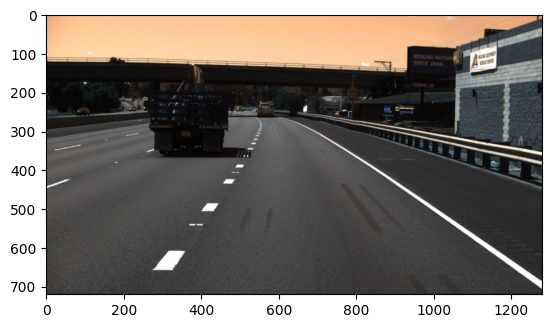

In [43]:
test_image = cv2.imread("./test_set/clips/0530/1492626047222176976_0/20.jpg")
plt.imshow(test_image)

In [44]:
detector = LaneDetector(enet=enet_model)
res = detector(test_image)

Detected 2 lanes


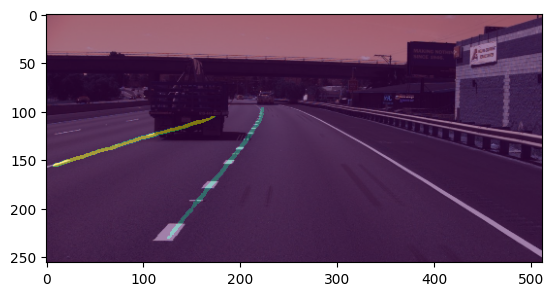

In [45]:
plt.imshow(cv2.resize(test_image, (512, 256)))
plt.imshow(res[0], alpha=0.5)

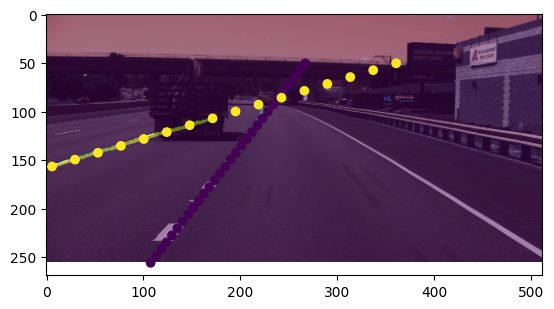

In [46]:
plt.imshow(cv2.resize(test_image, (512, 256)))
plt.imshow(res[0], alpha=0.5)
plt.scatter(x=res[1][:,0], y=res[1][:, 1], c=res[1][:, 2])

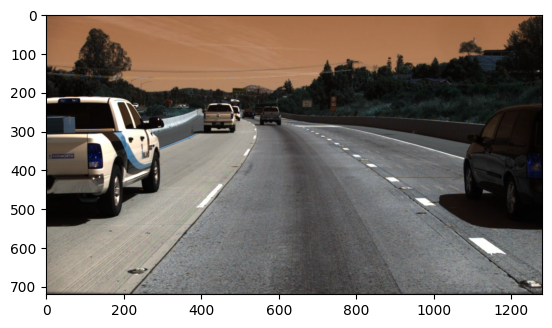

In [47]:
test_image_2 = cv2.imread("./test_set/clips/0530/1492626286076989589_0/20.jpg")
plt.imshow(test_image_2)

In [48]:
detector = LaneDetector(enet=enet_model)
res_2 = detector(test_image_2)

Detected 2 lanes


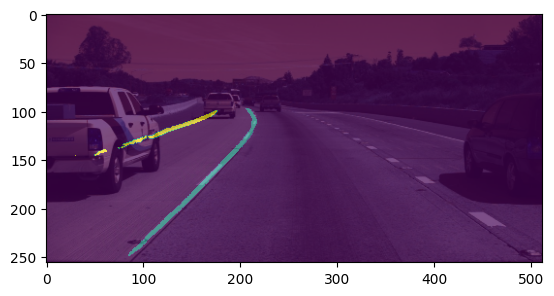

In [49]:
plt.imshow(cv2.resize(test_image_2, (512, 256)))
plt.imshow(res_2[0], alpha=0.7)

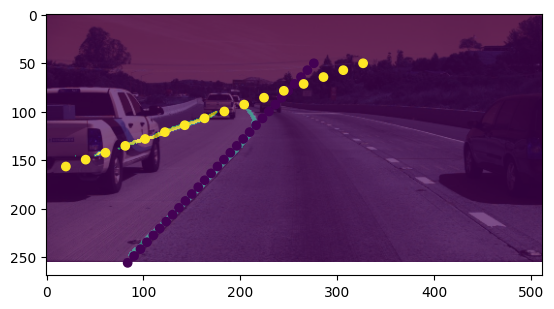

In [50]:
plt.imshow(cv2.resize(test_image_2, (512, 256)))
plt.imshow(res_2[0], alpha=0.7)
plt.scatter(x=res_2[1][:,0], y=res_2[1][:, 1], c=res_2[1][:, 2])

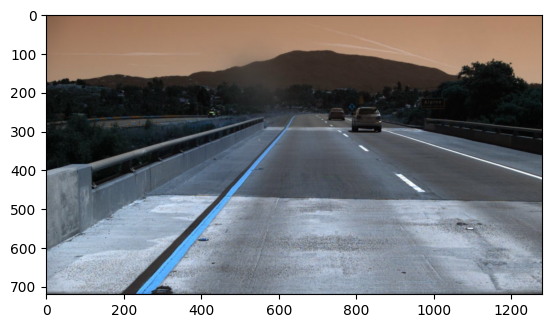

In [51]:
test_image_3 = cv2.imread("./test_set/clips/0531/1492626674406553912/20.jpg")
plt.imshow(test_image_3)

In [52]:
detector = LaneDetector(enet=enet_model)
res_3 = detector(test_image_3)

Detected 3 lanes


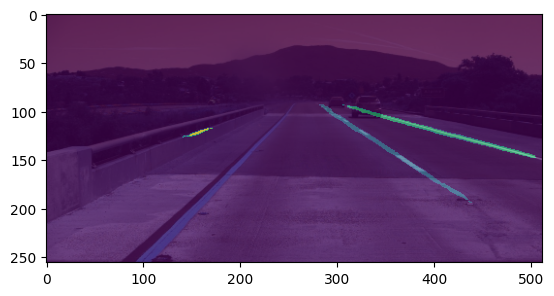

In [53]:
plt.imshow(cv2.resize(test_image_3, (512, 256)))
plt.imshow(res_3[0], alpha=0.7)

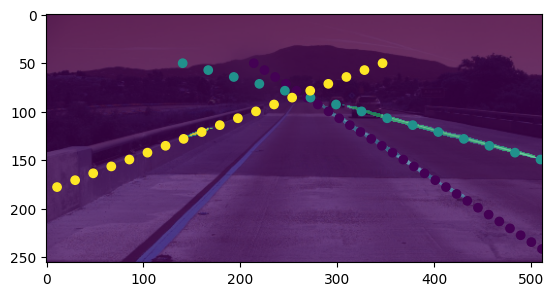

In [54]:
plt.imshow(cv2.resize(test_image_3, (512, 256)))
plt.imshow(res_3[0], alpha=0.7)
plt.scatter(x=res_3[1][:,0], y=res_3[1][:, 1], c=res_3[1][:, 2])

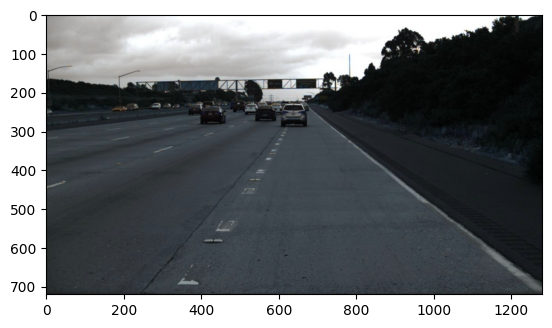

In [55]:
test_image_4 = cv2.imread("./test_set/clips/0601/1494452381594376146/20.jpg")
plt.imshow(test_image_4)

In [56]:
detector = LaneDetector(enet=enet_model)
res_4 = detector(test_image_4)

Detected 3 lanes


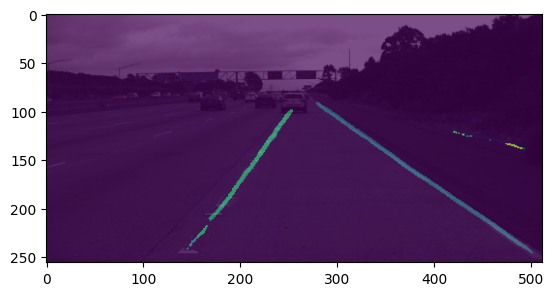

In [57]:
plt.imshow(cv2.resize(test_image_4, (512, 256)))
plt.imshow(res_4[0], alpha=0.7)

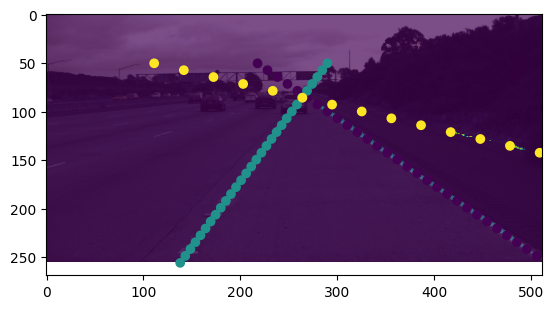

In [58]:
plt.imshow(cv2.resize(test_image_4, (512, 256)))
plt.imshow(res_4[0], alpha=0.7)
plt.scatter(x=res_4[1][:,0], y=res_4[1][:, 1], c=res_4[1][:, 2])

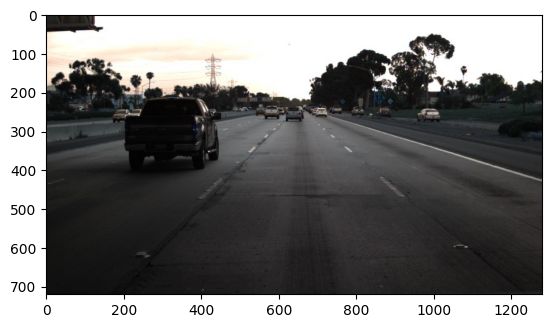

In [59]:
test_image_5 = cv2.imread("./test_set/clips/0601/1494452431571697487/20.jpg")
plt.imshow(test_image_5)

In [60]:
detector = LaneDetector(enet=enet_model)
res_5 = detector(test_image_5)

Detected 3 lanes


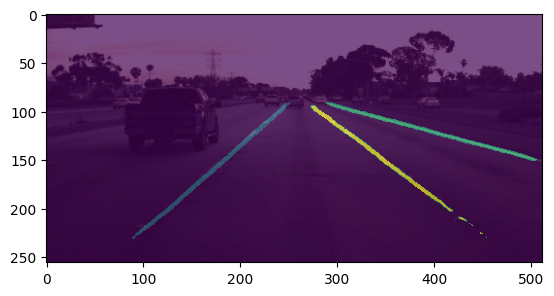

In [61]:
plt.imshow(cv2.resize(test_image_5, (512, 256)))
plt.imshow(res_5[0], alpha=0.7)

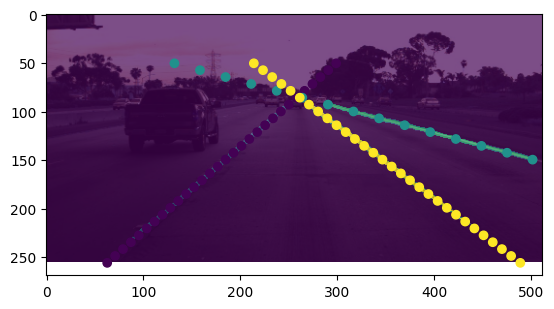

In [62]:
plt.imshow(cv2.resize(test_image_5, (512, 256)))
plt.imshow(res_5[0], alpha=0.7)
plt.scatter(x=res_5[1][:,0], y=res_5[1][:, 1], c=res_5[1][:, 2])

In [ ]:
torch.save(enet_model.state_dict(), 'lane_detection_model.pth')
